In [1]:
# Note: This is a hack to allow importing from the parent directory
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from models import ShallowAutoencoder
from data import CIFAR10GaussianSplatsDataset
from utils import train, test, transform, noop_collate, transform_and_collate

dataset = CIFAR10GaussianSplatsDataset(
    root="../data/CIFAR10GS",
    train=True,
    init_type="grid",
)

latent_dim = 128
input_dim = 23552

In [3]:
model = ShallowAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    collate_fn=transform_and_collate,
)
val_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=transform_and_collate,
)
test_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=transform_and_collate,
)
optimizer = optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=1e-5
)  # weight_decay is L2 regularization
criterion = nn.MSELoss()
epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
results = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=epochs,
    device=device,
)
train_results, val_results = results["train_loss"], results["val_loss"]

Epoch 1/1: 100%|██████████| 9/9 [00:01<00:00,  6.94batch/s]


Epoch 1/1 | Train Loss: 0.5895 | Val Loss: 0.4916
Train Loss: 0.5895 | Val Loss: 0.4916 | Training time: 1.91s


In [5]:
test_results = test(
    model=model, test_loader=test_loader, criterion=criterion, device=device
)

Test Loss: 0.4916 | Test time: 0.94s


In [6]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=noop_collate,
)

results = transform(model=model, data_loader=data_loader, device=device)

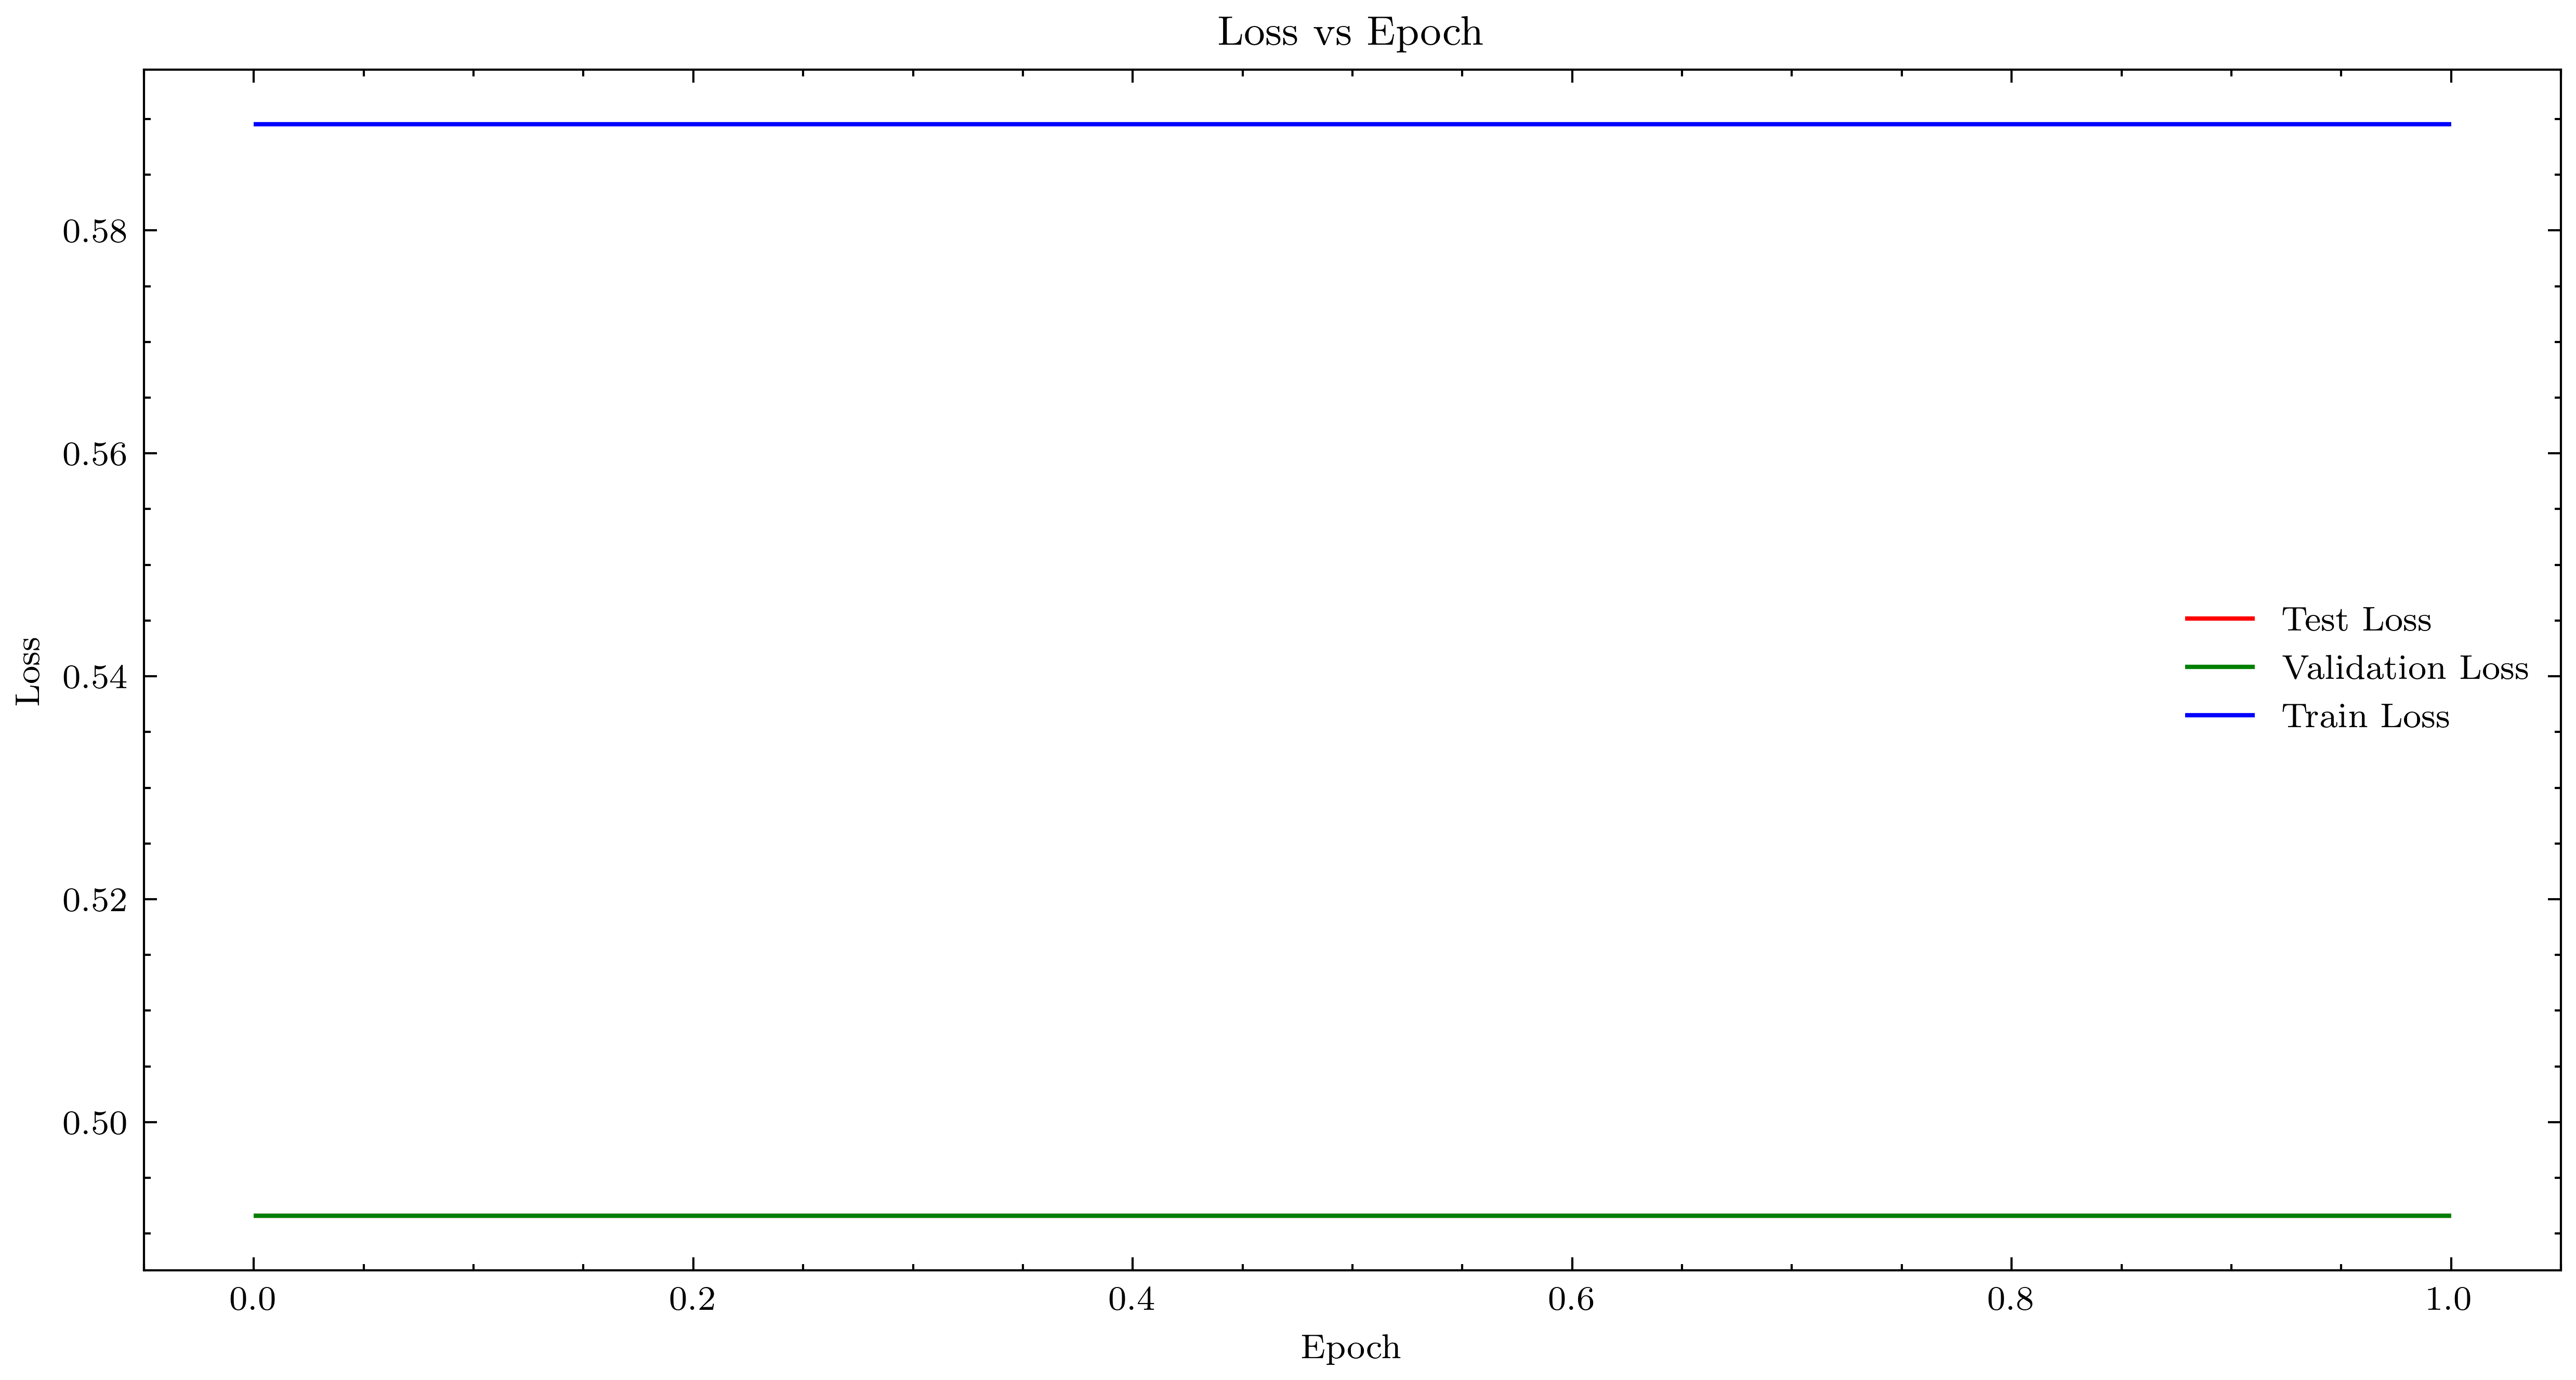

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("../style/main.mpltstyle")

# Plot train, validation and test results
plt.figure(figsize=(10, 5))
plt.hlines(y=test_results, xmin=0, xmax=epochs, label="Test Loss", color="red")
plt.hlines(y=val_results, xmin=0, xmax=epochs, label="Validation Loss", color="green")
plt.hlines(y=train_results, xmin=0, xmax=epochs, label="Train Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")
plt.title("Loss vs Epoch")
plt.savefig("../images/shallow_autoencoder_loss.png")
plt.show()